In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from lib import sauvola
# addition
from enum import Enum


class Binarisation(Enum):
    SAUVOLA = 1
    OTSU = 2


def mplot(img, img2=None):

    cv2.namedWindow('img', cv2.WINDOW_NORMAL)
    cv2.moveWindow('img', 600, 300)
    cv2.imshow('img', img)
    if img2 is not None:
        cv2.namedWindow('img2', cv2.WINDOW_NORMAL)
        cv2.moveWindow('img', 600, 600)
        cv2.imshow('img2', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


'''
function to rearrange the contour bounding boxes. in default the contour bounding boxes comes in the sorted order of
their y co-ordinates . this function returns a list of rectangles [(x1,y1,w1,h1),(x2,y2,w2,h2)...] which are sorted in
the order of x axis on each line. a line will have all recangles of y coordinates between y and y+h of first rectangle '''


def rearrange(cnt):
    b_rect = []
    for c in cnt:
        rect = cv2.boundingRect(c)
        if rect[2] <= 18 or rect[3] <= 18:
            continue
        b_rect.append(rect)
    if b_rect == []:
        return []
    p = b_rect[0][1]+b_rect[0][3]
    #print('length of brect:',len(b_rect))
    s_rect = []
    i = 0
    length = len(b_rect)
    while i < length:
        p = b_rect[i][1]+b_rect[i][3]
        elem_on_line = []  # elements on a line
        outer = True
        while i < length and p > b_rect[i][1]:
            elem_on_line.append(b_rect[i])
            i += 1
            outer = False
        if outer:
            i += 1
        elem_on_line = sorted(elem_on_line)  # ,key=lambda x:x[0]
        # print(elem_on_line,i)
        s_rect.extend(elem_on_line)
    return s_rect


'''
clear_noice method clear noice from list of images and retrun cleared list of images
'''


def clear_noice(image, ellipse=(7, 7), rect=(15, 7), method=Binarisation.OTSU):

    threshold = 128
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)
    cnt = []
    bw = image.copy()
    grad = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    if method == Binarisation.OTSU:
        _, bw = cv2.threshold(grad, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    elif method == Binarisation.SAUVOLA:
        bw = sauvola.binarize(grad, [20, 20], threshold, 0.110)
        bw = cv2.bitwise_not(bw)
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2)
    contours, hierarchy = cv2.findContours(
        connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # reversing contour list to start processig from top
    contours.reverse()
    cnt.extend(contours)
    #print('contour length:',len(contours))
    # mplot(grad,connected)
    return cv2.bitwise_not(bw), cnt


def printChars():
    for i, word in enumerate(seperated):
        for j, char in enumerate(word):
            mplot(char)


mal = np.load('malchar.npy')


def predict_word(p_word):
    pred = ''
    for i in p_word:
        pred += chr(mal[i])
    return pred


def splMean(img, thresh):
    sum = 0
    nt = 0
    for row in img:
        for elem in row:
            if elem > thresh:
                sum += elem
            else:
                nt += 1
    if sum != 0:
        avg = sum/(img.size-nt)
    else:
        avg = 0
    # print(avg)
    return avg

In [2]:
from keras.models import load_model
#predict word when a list of predicted classnames are given
model2=load_model('modelMHCR_gray_2.8.96.97.h5')  

Using TensorFlow backend.


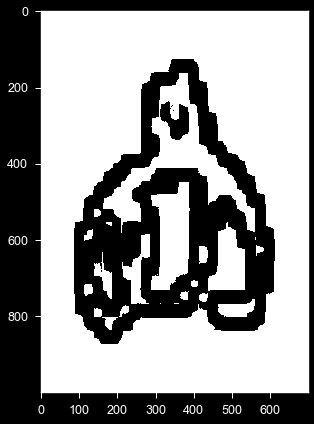

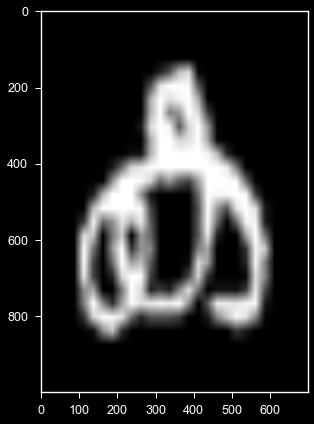

In [5]:
img_loc = 'D:/Projects/Research/MalayalamOCR/temp/Sample/Sample/111/image1.png'
img = cv2.bitwise_not(img)
img = cv2.resize(cv2.imread(img_loc, 0), (700, 1000))
# img=img[150:-200,30:-30]
img2 = img.copy()
bw, contours = clear_noice(img)
# if notebook is in dark mode else comment this line
plt.style.use('dark_background')
plt.imshow(bw, cmap='gray')
plt.show()
# cutting the image into list of words
s_rect = rearrange(contours)
words = []
i = 0
for rect in s_rect:
    x, y, w, h = rect
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 0, 0), 2)
    cv2.putText(img2, str(i), (x+w+10, y+h), 0, 0.3, (0, 0, 0))
    word = (img[y:y+h, x:x+w])
    ret, thresh4 = cv2.threshold(word, 127, 255, cv2.THRESH_TOZERO)
    # inc is the increment for differ
    inc = 1*(255-splMean(thresh4, 90))
    #ret,thresh4 = cv2.threshold(word,127,255,cv2.THRESH_BINARY)
    #thresh4 = cv2.adaptiveThreshold(word, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    word = np.array([[min(j+inc, 255) if j > 90 else j for j in thresh4[k]]
                     for k in range(len(thresh4))], dtype=np.uint8)
    # word=thresh4
    # mplot(thresh4,word)
    words.append(word)
    i += 1
# mplot(img2)
plt.imshow(img2, cmap='gray')

<h4> Drawing bounding boxes on each words</h4><br/>
<p> Here, word consists of list of words cropped.we are rearranging each word and drawing bounding rectangle to each characters  </p>

In [6]:
seperated=[]
#print(len(words))
for i in range(len(words)):
    
    _, c=clear_noice(words[i],ellipse=(3,3),rect=(2,2))
    s_rect=rearrange(c)
   # if i ==0:
     #   print("rect:",s_rect) 
    chars=[]
    if s_rect==[]:
        continue
    for rect in s_rect:
        x,y,w,h = rect
        char=words[i][y:y+h,x:x+w]
        char= cv2.copyMakeBorder(char,20,20,20,20,cv2.BORDER_CONSTANT,value=[255,255,255])
        char=cv2.resize(char,(86,86))
        chars.append(char)
        #mplot(char,words[i])
        #cv2.rectangle(words[i],(x,y),(x+w,y+h),(0,0,0),2)
        #cv2.putText(words[i],str(i),(x+w+10,y+h),0,0.3,(0,0,0))
           
    #mplot(words[i])
    seperated.append(chars)

output = []
#print(len(seperated))
#pred=model2.predict_class
with open ('opt.docx','w', encoding="utf-8") as file:
    for i,word in enumerate(seperated):
        if word ==[]:
            continue
        word=np.array(word)
        word2=word
        #print(word.shape)
        pred=model2.predict_classes(word.reshape(-1,86,86,1))
        #cv2.putText(words[i],predict_word(pred),(10,10),0,0.3,(0,255,0)) 
        pred_word = predict_word(pred)
        print(pred_word,'\n')
        output.append(pred_word)
        #print(str(pred_word)+ '\n')
        file.write(str(pred_word)+ '\n')
        splMean(words[i],90)
        #mplot(words[i])
    


    
#mplot(img2)
#import os
#osCommandString = "notepad.exe opt.txt"
#os.system(osCommandString)

ഋ 



In [11]:
#class and images
#cls_and_img=np.load('/home/jabir/Project/MHCR/cls_labels.npy',cls_label)
from docx import Document
from docx.shared import Inches

document = Document()

document.add_heading('Character Recognition', 0)
document.add_heading('Output', 3)

p = document.add_paragraph('')
for words in output:
    p.add_run(words).bold = True
    p.add_run(' ')

document.add_picture(input_img, width=Inches(3))
document.save('output.docx')

In [12]:
#npy file for prediction
#mal=np.load('/home/jabir/Project/MHCR/malchar.npy')
import os
osCommandString= "start output.docx"
os.system(osCommandString)

0

In [10]:
printChars()

In [76]:
#cv2.imwrite('/home/jabir/Project/MHCR/realtest/charset2.jpg',img)

True

In [4]:
print(mal)

[3333 3334 3335 3337 3339 3342 3343 3346 3349 3350 3351 3352 3353 3354
 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367 3368
 3370 3371 3372 3373 3374 3375 3376 3378 3381 3382 3383 3384 3385 3380
 3379 3377]


In [8]:
print(chr(68))

D
